<a href="https://colab.research.google.com/github/Prince-vaishya/Housing-Project/blob/main/HousingProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import sys
import sklearn
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [71]:
def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url,tarball_path)
  with tarfile.open(tarball_path) as housing_tarball:
    housing_tarball.extractall(path="datasets")
  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

/tmp/ipython-input-2654185319.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


In [72]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [73]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [74]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [75]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


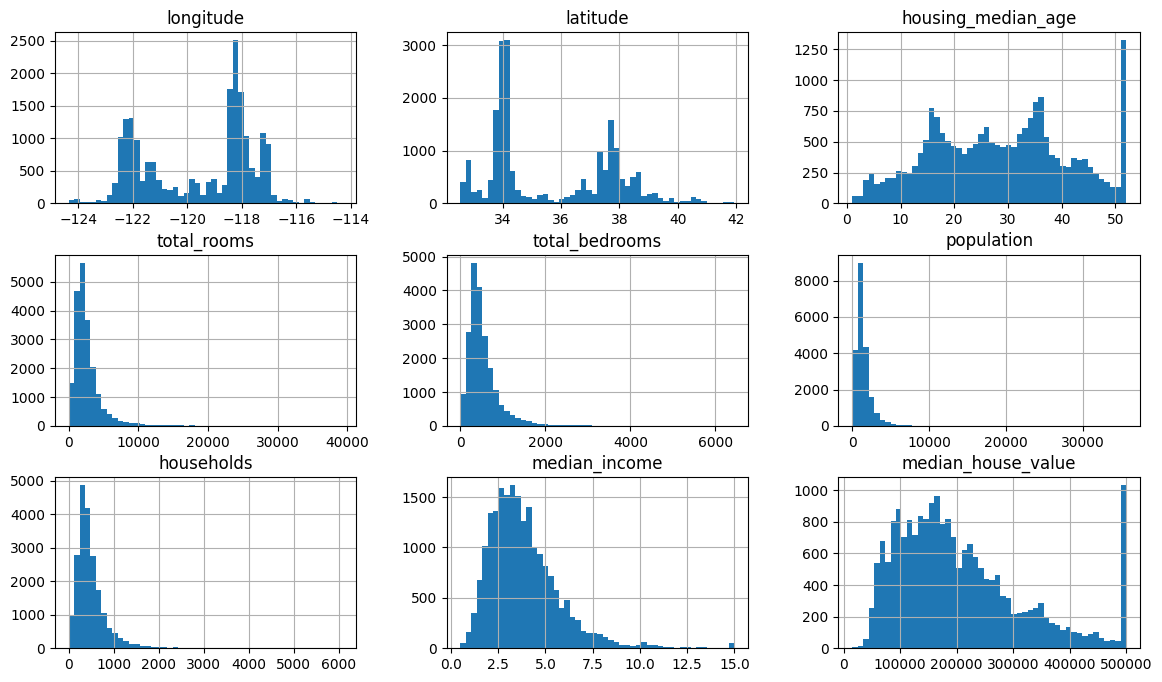

In [76]:
housing.hist(bins=50, figsize=(14,8))
plt.show()

In [77]:
def shuffle_and_split_data(data,test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]


In [78]:
train_set, test_set = shuffle_and_split_data(housing,0.2)

In [79]:
len(train_set)

16512

In [80]:
len(test_set)

4128

In [81]:
def is_id_in_test_set(identifier, test_ratio):
 return crc32(np.int64(identifier)) < test_ratio * 2**32

In [82]:
def split_data_with_id_hash(data, test_ratio, id_column):
 ids = data[id_column]
 in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
 return data.loc[~in_test_set], data.loc[in_test_set]

In [83]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [84]:
housing_with_id["id"]=housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id,0.2,"id")

In [85]:
train_set, test_set = train_test_split(housing,test_size=0.2,random_state=42)


In [86]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0.,1.5,3.0,4.5,6.,np.inf],
                               labels = [1,2,3,4,5])

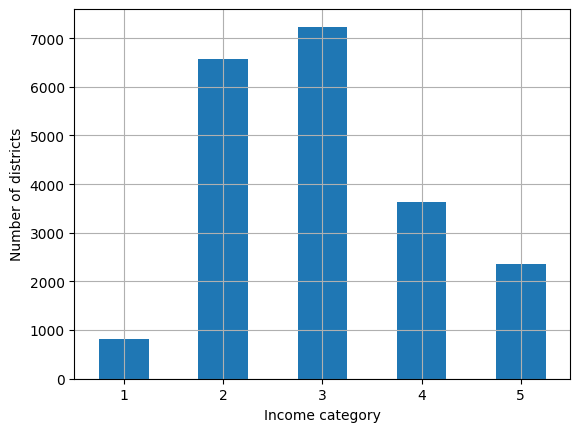

In [87]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [88]:
splitter = StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing,housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n,strat_test_set_n])

In [89]:
strat_train_set, strat_test_set = strat_splits[0]

In [90]:
strat_train_set, strat_test_set = train_test_split(housing,test_size=0.2,stratify=housing["income_cat"],random_state=42)

In [91]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)


,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [92]:
for set_ in(strat_train_set,strat_test_set):
  set_.drop("income_cat",axis=1,inplace=True)

In [93]:
housing = strat_train_set.copy()


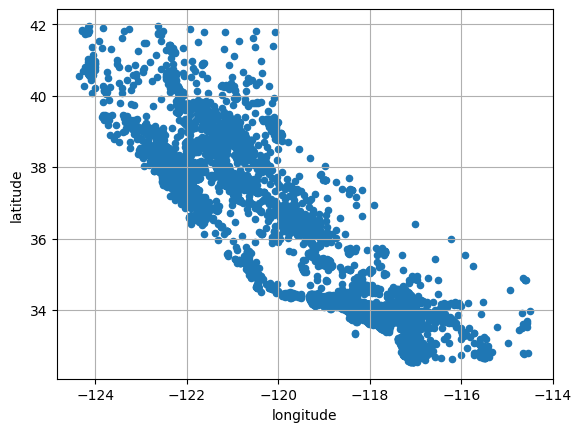

In [94]:
housing.plot(kind="scatter",x="longitude",y="latitude",grid="True")
plt.show()
# A geographical plot of data

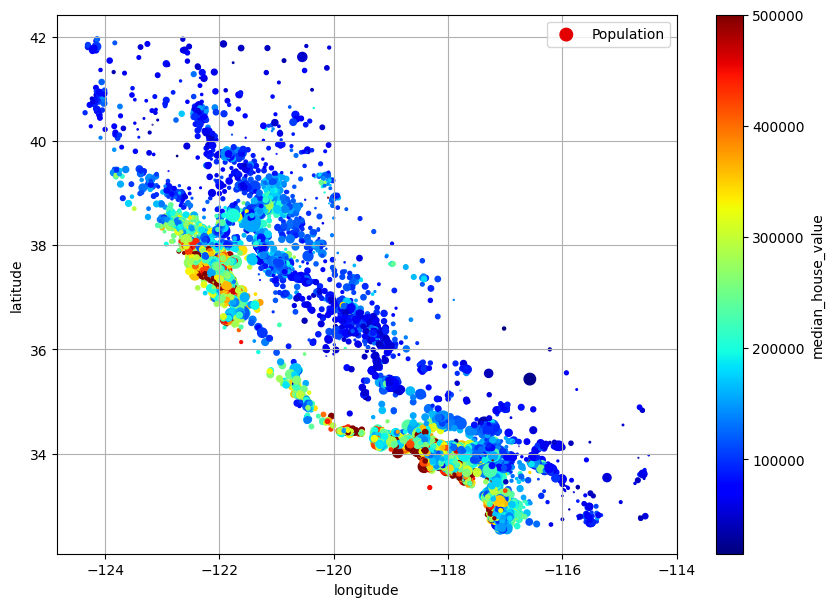

In [95]:
housing.plot(kind="scatter",x="longitude",y="latitude",grid=True,
             s=housing["population"]/100,label="Population",
             c="median_house_value",cmap="jet",colorbar=True,
             legend=True,sharex=False,figsize=(10,7))
plt.show()

# jet color map to represnt the price as per the population in latitude and logitude

In [96]:
housing_encoded = pd.get_dummies(housing, columns=["ocean_proximity"])
corr_matrix = housing_encoded.corr()

In [97]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
ocean_proximity_<1H OCEAN,0.257132
ocean_proximity_NEAR BAY,0.166398
ocean_proximity_NEAR OCEAN,0.138747
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
ocean_proximity_ISLAND,0.023258


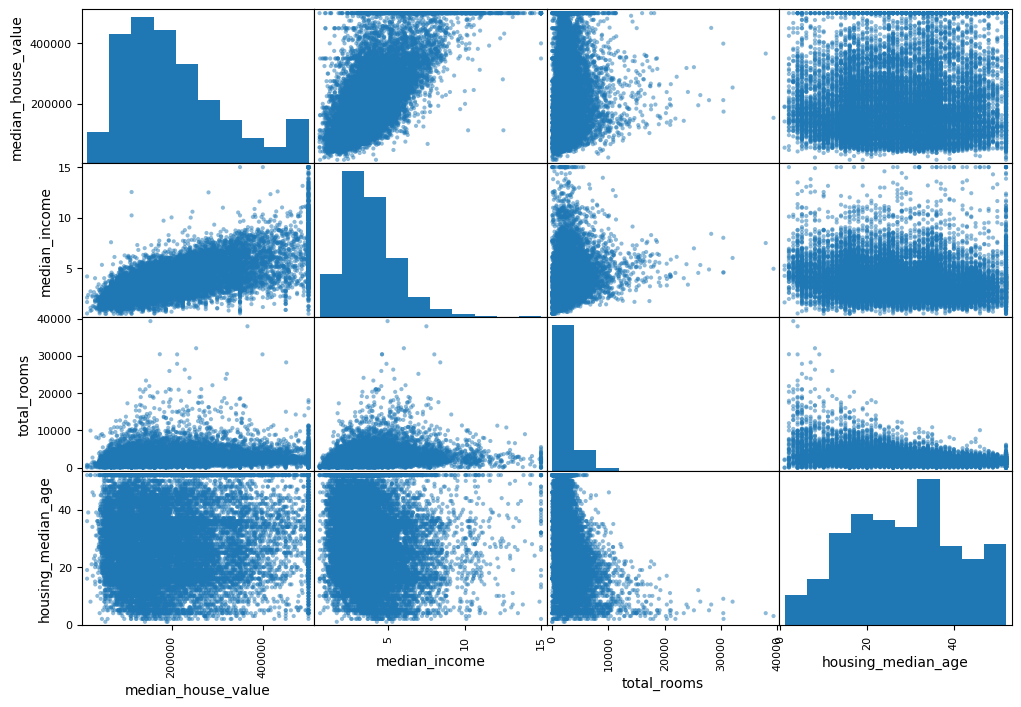

In [98]:
attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))
plt.show()

In [99]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"]= housing["population"]/housing["households"]

In [100]:
housing_encoded = pd.get_dummies(housing, columns=["ocean_proximity"])
corr_matrix = housing_encoded.corr()

In [101]:
corr_matrix = housing.select_dtypes(include=['number']).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


,median_house_value
median_house_value,1.000000
median_income,0.688380
rooms_per_house,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
people_per_house,-0.038224
longitude,-0.050859


In [102]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


# here we are separating the labels with other features from our dataset

In [103]:
# housing.dropna(subset=["total_bedrooms"], inplace=True)  option 1  we use this to get rid of corresponding districts which have null values
# housing.drop("total_bedrooms",axis=1) we do this to get rid of the attribute which has most null values

In [104]:
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median,inplace=True)

In [105]:
imputer = SimpleImputer(strategy="median")

So the reason we are using imputer instead of the preceeding code is because it will create median for each numerical value and since we have a column
'ocean_proximity' we need to create a copy of data with numerical value which we can do with the following code


In [106]:
housing_num  = housing.select_dtypes(include=[np.number])

In [107]:
imputer.fit(housing_num)
# here we are fitting the imputer instance to the training data

SimpleImputer(strategy='median')

In [108]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [109]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [110]:
X = imputer.transform(housing_num)

In [111]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,index=housing_num.index)

In [112]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [113]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat.to_frame())

# here we are converting the categorical text values into integers

In [114]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [115]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.to_frame())

In [116]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [117]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [118]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND","NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [119]:
cat_encoder.transform(df_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (2, 5)>

In [120]:
df_test_unknown = pd.DataFrame({"ocean_proximity":["<2H OCEAN","ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [121]:
cat_encoder.handle_unknown= "ignore"
cat_encoder.transform(df_test_unknown)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (2, 5)>

In [122]:
cat_encoder.feature_names_in_


array(['ocean_proximity'], dtype=object)

In [123]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [128]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns = cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [129]:
cat_encoder.transform(df_test_unknown).shape
cat_encoder.get_feature_names_out()


array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)